## Imports

In [1]:
# The OS module in Python provides functions for interacting with the operating system
import os

import itertools

# import the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tsa statsmodel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# keras, LSTM
#!pip install tensorflow
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#!pip install keras-tuner
import tensorflow as tf
import keras_tuner as kt

## Load Data

In [2]:
path1 = 'C:/Users/KNguyen/Desktop/springboard/Capstone3_AQI/data/processed/median_AQI_untransformed.csv'

df = pd.read_csv(path1, parse_dates=['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    509 non-null    datetime64[ns]
 1   AQI     509 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.1 KB


## Preprocessing

In [4]:
#https://www.youtube.com/watch?v=S8tpSG6Q2H0

In [5]:
# train test split
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

#test

In [6]:
# scaling
scaler = MinMaxScaler()
scaler.fit(train[['AQI']])
scaled_train = scaler.transform(train[['AQI']])
scaled_test = scaler.transform(test[['AQI']])

scaled_test

array([[0.39393939],
       [0.51515152],
       [0.48484848],
       [0.36363636],
       [0.18181818],
       [0.18181818],
       [0.21212121],
       [0.24242424],
       [0.3030303 ],
       [0.39393939],
       [0.42424242],
       [0.03030303]])

## Create LSTM model

In [7]:
# define generator

n_input = 12 #use previous 12 months to predict next month
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [8]:
# define (baseline) model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (n_input, n_features))) #input layer
model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mse')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit model
model.fit(generator, epochs=50)

Epoch 1/50
485/485 [==============================] - 6s 6ms/step - loss: 0.0240
Epoch 2/50
485/485 [==============================] - 3s 6ms/step - loss: 0.0113
Epoch 3/50
485/485 [==============================] - 3s 7ms/step - loss: 0.0085
Epoch 4/50
485/485 [==============================] - 4s 7ms/step - loss: 0.0072
Epoch 5/50
485/485 [==============================] - 3s 6ms/step - loss: 0.0074
Epoch 6/50
485/485 [==============================] - 3s 6ms/step - loss: 0.0062
Epoch 7/50
485/485 [==============================] - 3s 7ms/step - loss: 0.0060
Epoch 8/50
485/485 [==============================] - 4s 9ms/step - loss: 0.0059
Epoch 9/50
485/485 [==============================] - 3s 7ms/step - loss: 0.0060
Epoch 10/50
485/485 [==============================] - 3s 6ms/step - loss: 0.0061
Epoch 11/50
485/485 [==============================] - 3s 7ms/step - loss: 0.0056
Epoch 12/50
485/485 [==============================] - 3s 7ms/step - loss: 0.0053
Epoch 13/50
485/485 [====

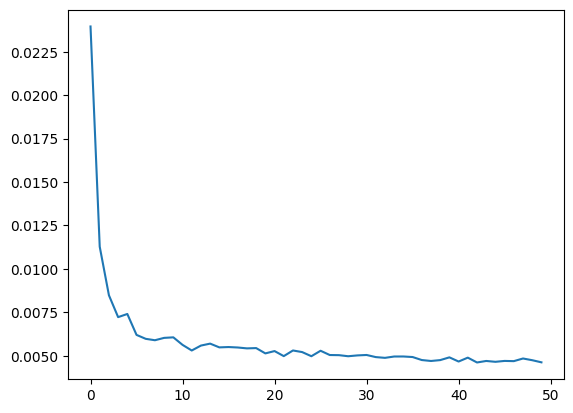

In [11]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [12]:
last_train_batch = scaled_train[-12:]

In [13]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [14]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction value for 1st batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction onto the array
    test_predictions.append(current_pred)
    
    # use the prediction to update the batch and remove the 1st value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 39ms/step


In [15]:
test_predictions

[array([0.4257251], dtype=float32),
 array([0.37546295], dtype=float32),
 array([0.2922787], dtype=float32),
 array([0.21047568], dtype=float32),
 array([0.1626802], dtype=float32),
 array([0.15095998], dtype=float32),
 array([0.16914937], dtype=float32),
 array([0.21533519], dtype=float32),
 array([0.28505093], dtype=float32),
 array([0.35641575], dtype=float32),
 array([0.4083259], dtype=float32),
 array([0.4319471], dtype=float32)]

In [16]:
true_predictions = scaler.inverse_transform(test_predictions)

test['Predictions'] = true_predictions

C:\Users\KNguyen\AppData\Local\Temp\ipykernel_5304\2110937659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [17]:
test

,Date,AQI,Predictions
497,2021-06-30,41.0,42.048928
498,2021-07-31,45.0,40.390277
499,2021-08-31,44.0,37.645197
500,2021-09-30,40.0,34.945698
501,2021-10-31,34.0,33.368446
502,2021-11-30,34.0,32.981679
503,2021-12-31,35.0,33.581929
504,2022-01-31,36.0,35.106061
505,2022-02-28,38.0,37.406681
506,2022-03-31,41.0,39.761720


<AxesSubplot: >

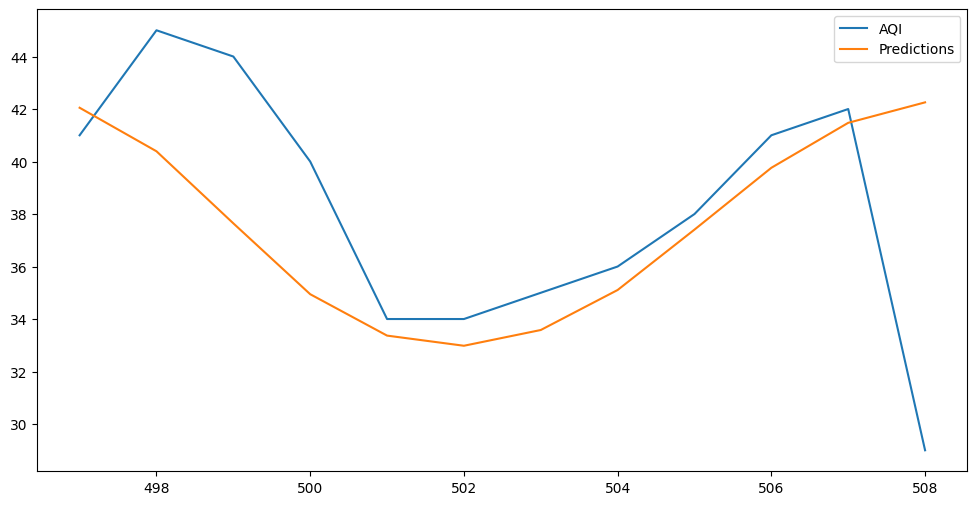

In [18]:
test[['AQI', 'Predictions']].plot(figsize=(12,6))

In [19]:
rmse = np.sqrt(mean_squared_error(test.AQI, test.Predictions))
print(rmse)

4.74659253163856


## Hyperparameter Tuning

In [20]:
#https://www.analyticsvidhya.com/blog/2021/08/hyperparameter-tuning-of-neural-networks-using-keras-tuner/
#https://www.youtube.com/watch?v=Clo1HKB50Ug

from keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [21]:
# scaled train/test data
scaled_train = scaler.transform(train[['AQI']])
scaled_test = scaler.transform(test[['AQI']])

n_input = 12 #use previous 12 months to predict next month
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# define (baseline) model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (n_input, n_features))) #input layer
model.add(Dense(1)) #output layer
model.compile(optimizer='adam', loss='mse')

In [22]:
#https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
def build_model(hp):
    
    model = Sequential()
    # choose number of neurons
    model.add(LSTM(hp.Int('input_unit',min_value=30,max_value=360,step=30),\
                   # makes the output usable to another LSTM
                   return_sequences=True,\
                   input_shape = (n_input, n_features)))
    
    # choose number of layers
    for i in range(hp.Int('n_layers', 1, 4)): 
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=30,max_value=360,step=30),return_sequences=True))
        
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=30,max_value=360,step=30)))
    
    # Choose best Dropout rate
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    
    # Dense layer and choice of activation ftn: relu or sigmoid
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    
    # compile
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model

In [23]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1
        )

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [24]:
tuner.search(
        x=scaled_train,
        y=scaled_train,
        epochs=30,
        batch_size=1,
        validation_data=(scaled_test,scaled_test),
)

INFO:tensorflow:Oracle triggered exit


In [25]:
best_model = tuner.get_best_models(num_models=1)[0]

In [26]:
best_model.fit(generator, epochs=30)

Epoch 1/30
485/485 [==============================] - 48s 58ms/step - loss: 0.0492 - mse: 0.0492
Epoch 2/30
485/485 [==============================] - 29s 60ms/step - loss: 0.0339 - mse: 0.0339
Epoch 3/30
485/485 [==============================] - 34s 70ms/step - loss: 0.0333 - mse: 0.0333
Epoch 4/30
485/485 [==============================] - 33s 68ms/step - loss: 0.0324 - mse: 0.0324
Epoch 5/30
485/485 [==============================] - 29s 61ms/step - loss: 0.0144 - mse: 0.0144
Epoch 6/30
485/485 [==============================] - 29s 60ms/step - loss: 0.0090 - mse: 0.0090
Epoch 7/30
485/485 [==============================] - 31s 65ms/step - loss: 0.0083 - mse: 0.0083
Epoch 8/30
485/485 [==============================] - 29s 59ms/step - loss: 0.0084 - mse: 0.0084
Epoch 9/30
485/485 [==============================] - 28s 57ms/step - loss: 0.0084 - mse: 0.0084
Epoch 10/30
485/485 [==============================] - 28s 57ms/step - loss: 0.0085 - mse: 0.0085
Epoch 11/30
485/485 [========

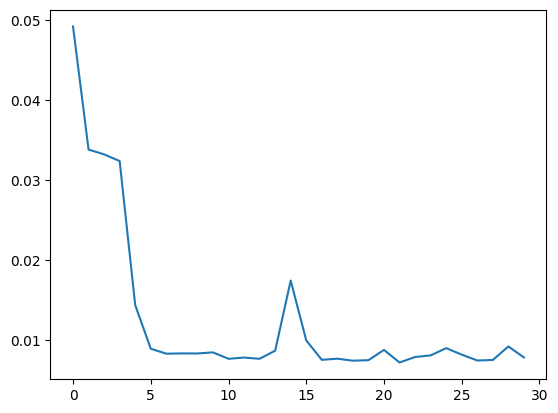

In [27]:
loss_per_epoch = best_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [28]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction value for 1st batch
    current_pred = best_model.predict(current_batch)[0]
    
    # append the prediction onto the array
    test_predictions.append(current_pred)
    
    # use the prediction to update the batch and remove the 1st value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 52ms/step


In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

test['Predictions'] = true_predictions

C:\Users\KNguyen\AppData\Local\Temp\ipykernel_5304\2110937659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [31]:
test

,Date,AQI,Predictions
497,2021-06-30,41.0,41.145915
498,2021-07-31,45.0,40.264536
499,2021-08-31,44.0,38.561312
500,2021-09-30,40.0,36.166938
501,2021-10-31,34.0,35.014723
502,2021-11-30,34.0,35.014965
503,2021-12-31,35.0,35.533338
504,2022-01-31,36.0,35.534157
505,2022-02-28,38.0,36.911356
506,2022-03-31,41.0,39.474045


<AxesSubplot: >

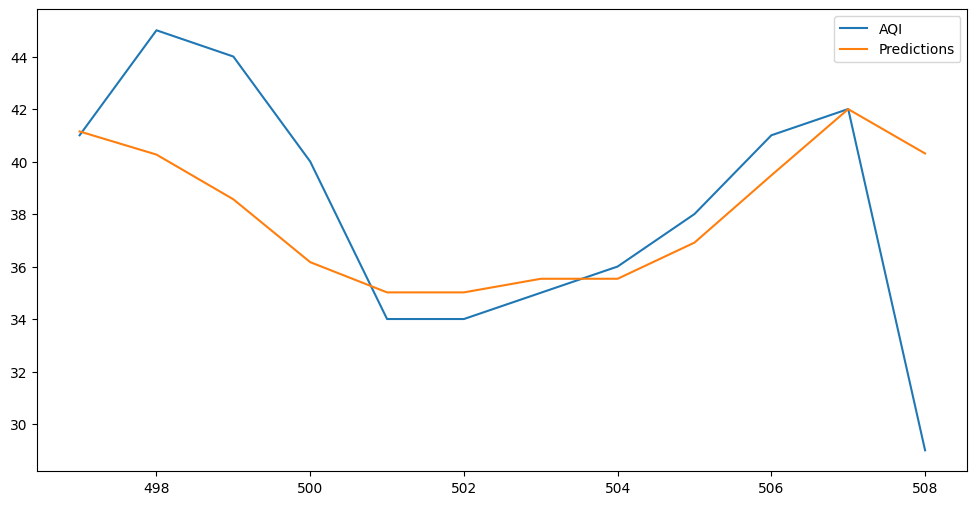

In [32]:
test[['AQI', 'Predictions']].plot(figsize=(12,6))

In [33]:
rmse = np.sqrt(mean_squared_error(test.AQI, test.Predictions))
print(rmse)

4.0889172414118535


In [34]:
# rmse of best_model is slightly lower than the SARIMA model (RMSE:  4.31), but higher than Prophet (RMSE:  2.58).